In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/My Drive/FFRS")
!ls -l

total 364772
-rw------- 1 root root   2069227 Jul 22 17:16 ab.csv
-rw------- 1 root root 102955153 Jul 22 13:59 storage_sample_stage4.h5
-rw------- 1 root root 119333798 Jul 22 17:07 train_pos_after_eda.csv
-rw------- 1 root root 149167209 Jul 22 13:59 train_woheader.csv


<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [3]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [4]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('storage_sample_stage4.h5', 'test_df',mode='r')

In [5]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [6]:
df_final_test.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

<h3>Number of followers of destination is missing so adding that to dataframe in the subseqent code blocks</h3>

In [7]:
d=df_final_train[['source_node','destination_node']]
train_graph=nx.from_pandas_edgelist(d,'source_node','destination_node',create_using=nx.DiGraph())

In [8]:
print(nx.info(train_graph))

Name: 
Type: DiGraph
Number of nodes: 183558
Number of edges: 100002
Average in degree:   0.5448
Average out degree:   0.5448


In [9]:
def compute_features_stage1(df_final):
    num_followers_d=[]
    for i,row in df_final.iterrows():
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
        except:
            d1 = set()
        num_followers_d.append(len(d1))    
    return  num_followers_d

In [10]:
df_final_train['num_followers_d']=compute_features_stage1(df_final_train)

In [11]:
df_final_test['num_followers_d']=compute_features_stage1(df_final_test)

<h3> Adding a feature of Prefrential Attachment for both followers and followees.</h3>


In [12]:
df_final_train['p_attch_followers']=df_final_train.apply(lambda row: row['num_followers_d']*row['num_followers_s'],axis=1)
df_final_train['p_attch_followees']=df_final_train.apply(lambda row: row['num_followees_d']*row['num_followees_s'],axis=1)

In [13]:
df_final_test['p_attch_followers']=df_final_train.apply(lambda row: row['num_followers_d']*row['num_followers_s'],axis=1)
df_final_test['p_attch_followees']=df_final_train.apply(lambda row: row['num_followees_d']*row['num_followees_s'],axis=1)

In [14]:
df_final_test.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'num_followers_d', 'p_attch_followers', 'p_attch_followees'],
      dtype='object')

In [15]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'num_followers_d', 'p_attch_followers', 'p_attch_followees'],
      dtype='object')

<h3> Adding a feature of SVD dot for both V and U columns.</h3>


In [16]:
df_final_train['svd_dot_v']=\
df_final_train.apply(lambda row: np.array(row[['svd_v_s_1', 'svd_v_s_2','svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']]).dot\
                                                 (np.array(row[['svd_v_d_1', 'svd_v_d_2','svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6']])),axis=1)
df_final_train['svd_dot_U']=\
df_final_train.apply(lambda row: np.array(row[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']]).dot\
                                                 (np.array(row[['svd_u_d_1', 'svd_u_d_2','svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6']])),axis=1)

In [17]:
# multiplying U and V of both source node and destination node so as to get a picture of ranked matrices(top 6 ranked matrices) without the sigma 
# amplification to it.
df_final_train['svd_dot_s_uv']=\
df_final_train.apply(lambda row: np.array(row[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']]).dot\
                                                 (np.array(row[['svd_v_s_1', 'svd_v_s_2','svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']])),axis=1)
df_final_train['svd_dot_d_uv']=\
df_final_train.apply(lambda row: np.array(row[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']]).dot\
                                                 (np.array(row[['svd_v_s_1', 'svd_v_s_2','svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']])),axis=1)


In [18]:
df_final_test['svd_dot_v']=\
df_final_test.apply(lambda row: np.array(row[['svd_v_s_1', 'svd_v_s_2','svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']]).dot\
                                                 (np.array(row[['svd_v_d_1', 'svd_v_d_2','svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6']])),axis=1)
df_final_test['svd_dot_U']=\
df_final_test.apply(lambda row: np.array(row[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']]).dot\
                                                 (np.array(row[['svd_u_d_1', 'svd_u_d_2','svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6']])),axis=1)

In [19]:
# multiplying U and V of both source node and destination node so as to get a picture of ranked matrices(top 6 ranked matrices) without the sigma 
# amplification to it.
df_final_test['svd_dot_s_uv']=\
df_final_test.apply(lambda row: np.array(row[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']]).dot\
                                                 (np.array(row[['svd_v_s_1', 'svd_v_s_2','svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']])),axis=1)
df_final_test['svd_dot_d_uv']=\
df_final_test.apply(lambda row: np.array(row[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']]).dot\
                                                 (np.array(row[['svd_v_s_1', 'svd_v_s_2','svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']])),axis=1)


In [20]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'num_followers_d', 'p_attch_followers', 'p_attch_followees',
       'svd_dot_v', 'svd_dot_U', 'svd_dot_s_uv', 'svd_dot_d_uv'

In [21]:
df_final_test.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'num_followers_d', 'p_attch_followers', 'p_attch_followees',
       'svd_dot_v', 'svd_dot_U', 'svd_dot_s_uv', 'svd_dot_d_uv'

In [22]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [23]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

In [24]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(30,125),
              "max_depth": sp_randint(10,20),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25,return_train_score=True)

rf_random.fit(df_final_train,y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
              

In [25]:
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])


mean test scores [0.96194366 0.96213534 0.96224763 0.96317524 0.96107009]
mean train scores [0.96259418 0.96293055 0.96299638 0.96396628 0.96180168]


In [26]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=111,
                       min_weight_fraction_leaf=0.0, n_estimators=69, n_jobs=-1,
                       oob_score=False, random_state=25, verbose=0,
                       warm_start=False)


In [40]:
clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=111,
                       min_weight_fraction_leaf=0.0, n_estimators=69, n_jobs=-1,
                       oob_score=False, random_state=25, verbose=0,
                       warm_start=False)

In [41]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [42]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9652128133479123
Test f1 score 0.9262892553303224


In [43]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


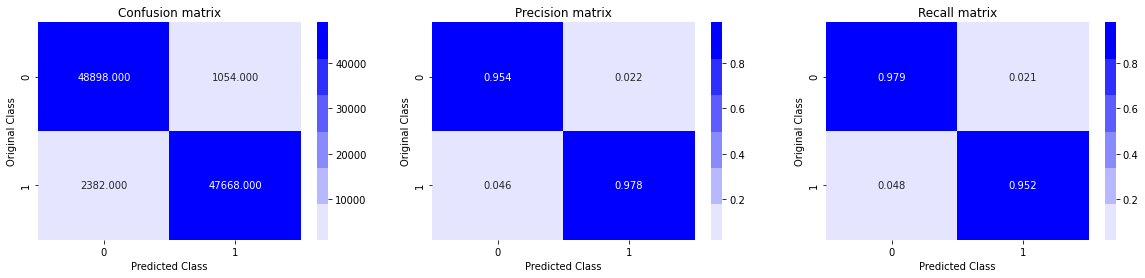

Test confusion_matrix


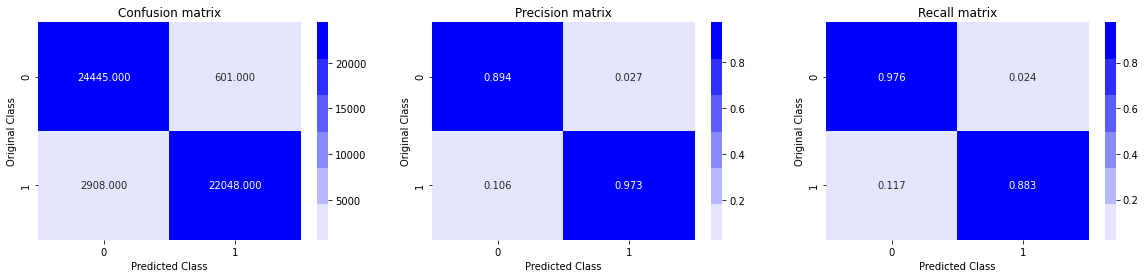

In [44]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

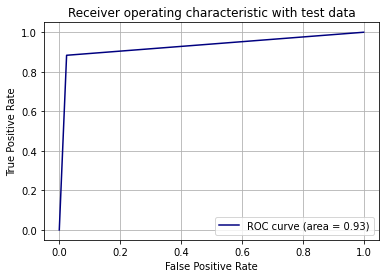

In [45]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.grid()
plt.show()

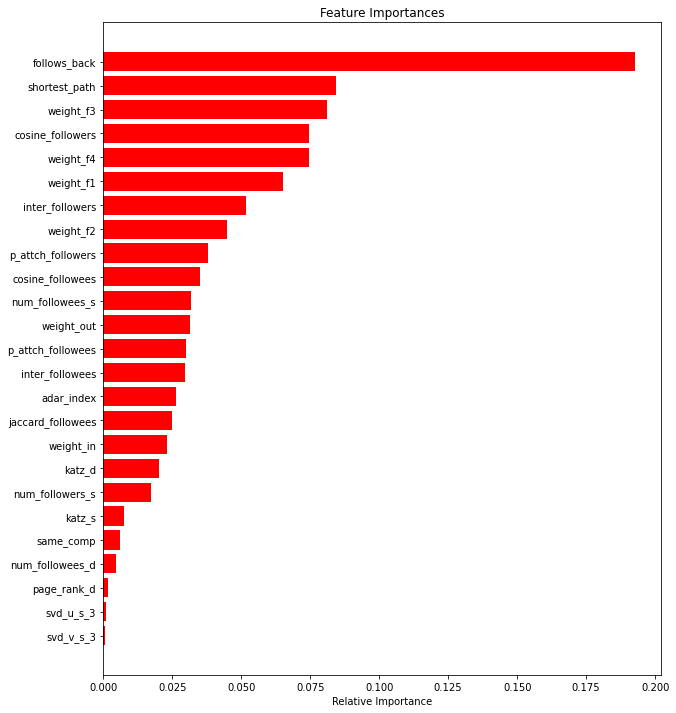

In [46]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Applying logistic Regression

In [47]:
from sklearn.metrics import f1_score
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV

param_dist = {"alpha":[10**i for i in range(-10,1)]}

clf = SGDClassifier(loss='log', penalty='l2')

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   cv=10,scoring='f1',random_state=25,return_train_score=True)

rf_random.fit(df_final_train,y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=SGDClassifier(alpha=0.0001, average=False,
                                           class_weight=None,
                                           early_stopping=False, epsilon=0.1,
                                           eta0=0.0, fit_intercept=True,
                                           l1_ratio=0.15,
                                           learning_rate='optimal', loss='log',
                                           max_iter=1000, n_iter_no_change=5,
                                           n_jobs=None, penalty='l2',
                                           power_t=0.5, random_state=None,
                                           shuffle=True, tol=0.001,
                                           validation_fraction=0.1, verbose=0,
                                           warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'

In [48]:
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.78696243 0.87745299 0.86533197 0.81762768 0.86091715 0.88372137
 0.84261695 0.77089564 0.82324448 0.85759032]
mean train scores [0.78753853 0.87738519 0.86573605 0.81789721 0.86074141 0.88345696
 0.84141737 0.77098328 0.82318445 0.85752604]


In [49]:
print(rf_random.best_estimator_)

SGDClassifier(alpha=1e-05, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


In [50]:
clf = SGDClassifier(alpha=1e-05, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [51]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [52]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.8861745835778908
Test f1 score 0.6925535885245103


In [53]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


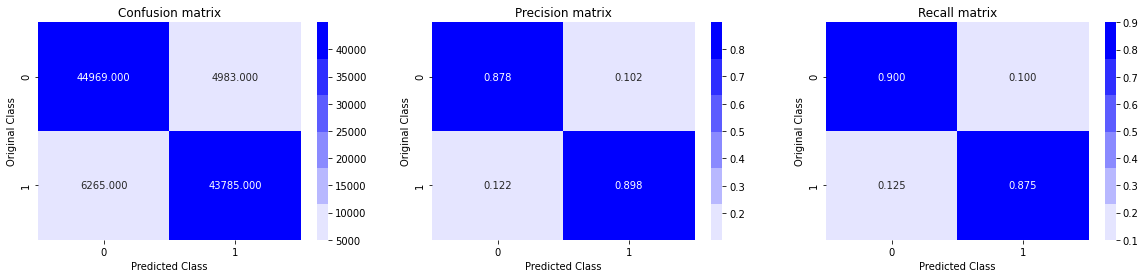

Test confusion_matrix


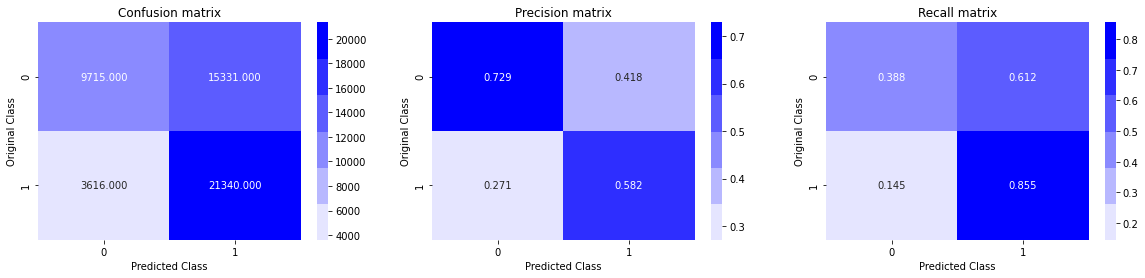

In [54]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

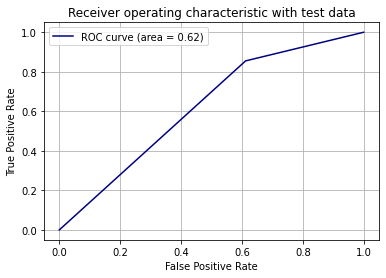

In [55]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.grid()
plt.show()

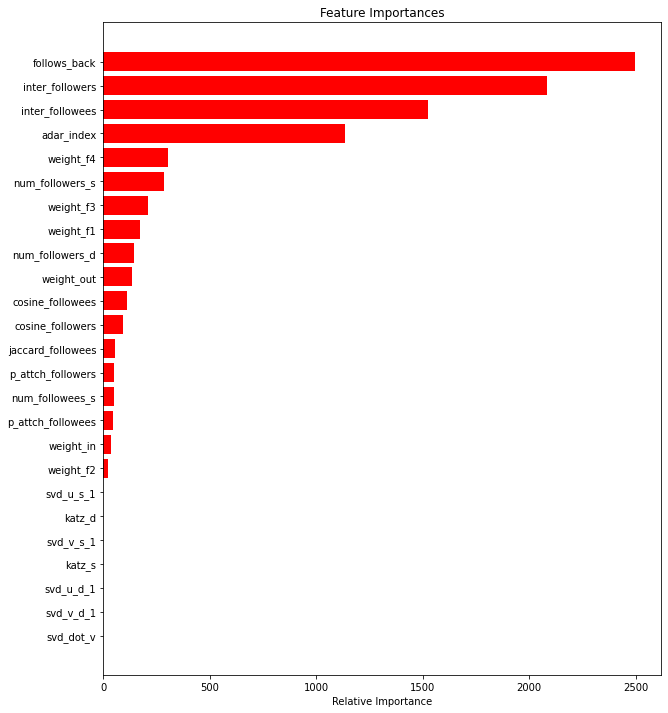

In [65]:
features = df_final_train.columns
importances = clf.coef_[0]
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# work flow


Given Problem is Called Facebook friend recommendation system. This problem tries to predict whom one is likely to make a friend from a given group of people. The provided data constitute only a 2 column csv file which shows a follower-followee relation. It consists of about 1.86 million datapoints/users with a 9.4 millon approximate connections among them.These are directed connections. This is basically a  ### graph Problem ### and we will generate features from this graph to using certain graph mining techniques so as to feed our ML models to work on. 
1. Basic EDA shows 99% of data having followers/Followees of 40 only.
2. 14 precent people dont follow anyone and 10 percent people dont have followers while their intersection is null.
3. Min of no of followers + following is 1.
334291  persons having minimum no of followers + following
4. Max of no of followers + following is 1579.
1  persons having maximum no of followers + following
5. As this problem statement does not provide with connections that dont exits we create some ourselves to make this problem a binary classification problem with balanced dataset.
6. This new data points are generated on basis of domain knowledge which says probability of a connection happening if shortest path lenght is more than 2 is unlikly. so we generate source destination pairs as such only. 
7. To feturize this data we make use of NetworkX python package which as graph mining fucntions inbuilt.
8. first is jaccard distace which measures the ratio of common followers/followees to total followers/followees for a given pair.
9. We also measure cosine distance for followers/followees.
10. other feature imporatnces include Ranking users based on page rank method,
shortest path lenght, weak connections, adar index, follow back, katz centrality, hub or authotrity, number of followers/followees, inter followers/followees and weight edges of source and destination along with some linear combinations of them.
11. We also did matrix factorizaiton using svd and used top six components.
based on that also added a svd dot feature for source and destioation as well as U dot V
12. Another featurization added was Prefrential matching which is along the lines of 'rich getting richer' theory.
13. modeling of this data involes neatly splitting the data into train and test without any information leakage.
14. Random forest and Logistic Regression are trained with hyperpaarameter tunnning.
15. Randon forests seems to do better than a simple linear model as intuition of data says.
16. Models are evaluated using F1 score as both precision and recall matters in the problem, while latency was not a major concer.
17. Feature importanc is shown using a Bar graph for both the models.


In [66]:
print("Tabulation of results for RBF SVM")
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["S.NO.", "MODEL", "Train Score","Test Score"]
x.add_row(["1", "Random Forest","96.52%","92.62%"])
x.add_row(["2", "Logistic Regression","88.61%","69.25%"])
print(x)

Tabulation of results for RBF SVM
+-------+---------------------+-------------+------------+
| S.NO. |        MODEL        | Train Score | Test Score |
+-------+---------------------+-------------+------------+
|   1   |    Random Forest    |    96.52%   |   92.62%   |
|   2   | Logistic Regression |    88.61%   |   69.25%   |
+-------+---------------------+-------------+------------+
